In [1]:
import os
os.chdir('../')

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances

In [3]:
lr = (0.1, 0.01, 0.001)
batch_size = (128, 512, 1024)

# Permute all hyperparameters
hyperparams = []
for lr_ in lr:
    for batch_size_ in batch_size:
        hyperparams.append({
            'lr': lr_,
            'lambda_l1': 0.0,
            'patience': 10,
            'epochs': 200,
            'batch_size': batch_size_,
        })
        
print(f'Number of hyperparameters: {len(hyperparams)}')

Number of hyperparameters: 9


In [4]:

env_steps = Concept.load_concept_data()

model_path = 'runs/20240128-235322'
models = os.listdir(model_path)
# Number of steps from file name
models = [(f, int(f.split('_')[1].replace('.pt',''))) for f in models if f.endswith(".pt")]
# Sort on the number of steps
models.sort(key=lambda x: x[1])
models = models[:4]

In [5]:
def create_concept_evolution(concept, models, layers):
    train_steps = [m[1] for m in models]
    concept.prepare_data(env_steps, max_size=5000)
    input_score = None
    
    scores = {}
    x, y = np.meshgrid(train_steps, layers)
    scores['x'] = x
    scores['y'] = y
    scores['z'] = np.zeros((len(layers), len(train_steps)))
    
    for step_index, step in enumerate(train_steps):
        path = os.path.join(model_path, f'model_{step}.pt')
        model = QNetwork(frame_stacks=4, model_path=path)
        #print("Probing model:", path)
        # If it's the first model, get the input score
        if input_score is None:
            layer_probes, layer_info, best_hyperparams = train_probes(model, concept, hyperparams, [-1] + layers)
            input_score = layer_info[-1]['test_score'][-1]
        else:
            layer_probes, layer_info, best_hyperparams = train_probes(model, concept, hyperparams, layers)
        for layer_index, layer in enumerate(layers):
            score = layer_info[layer]['test_score'][-1]
            #print(f'Layer {layer_index} | Step {step} | Score: {score:.3f}')
            scores['z'][layer_index][step_index] = score
    
        print(f'Best hyperparameters: {best_hyperparams}')
    with open(f'{concept.folder_path}/evolution.pkl', 'wb') as f:
        pickle.dump(scores, f)
        
    train_steps = np.array(train_steps)
    z_input = np.full(scores['z'].shape, input_score)

    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection='3d')
    ax.text2D(0.5, 0.9, f'{concept.name}', transform=ax.transAxes, ha='center', fontsize=20)
    ax.view_init(elev=30, azim=210)
    
    '''
    ax.plot_surface(np.log10(scores['x']+1), scores['y'], z_input, vmin=0, vmax=1, alpha=0.5, cmap=cm.plasma)
    ax.plot_surface(np.log10(scores['x']+1), scores['y'], np.maximum(0, scores['z']), vmin=0, vmax=1, cmap=cm.plasma)

    ax.set_xlabel('Training steps', fontsize=12, labelpad=10)
    ax.set_xticks(np.log10([1, 10**3, 10**5, 10**7]))
    ax.set_xticklabels(['$0$', '$10^3$', '$10^5$', '$10^7$'])
    '''

    ax.plot_surface(scores['x'], scores['y'], z_input, vmin=0, vmax=1, alpha=0.5)#, cmap=cm.plasma)
    ax.plot_surface(scores['x'], scores['y'], np.maximum(0, scores['z']), vmin=0, vmax=1, cmap=cm.plasma)

    ax.set_xlabel('Training steps', fontsize=12, labelpad=10)
    labeled_train_steps = train_steps[::2]
    ax.set_xticks(labeled_train_steps)
    ax.set_xticklabels([f'{step//1000000}m' for step in labeled_train_steps])

    ax.set_ylabel('Layer', fontsize=12, labelpad=10)
    ax.set_yticks(layers)
    ax.set_yticklabels(layers)
    ax.set_zlabel('Score', fontsize=12)
    ax.set_box_aspect(aspect=None, zoom=0.8)

    ax.set_zlim(0, 1)
    plt.savefig(f'{concept.folder_path}/evolution.png')
    plt.show()

Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs'

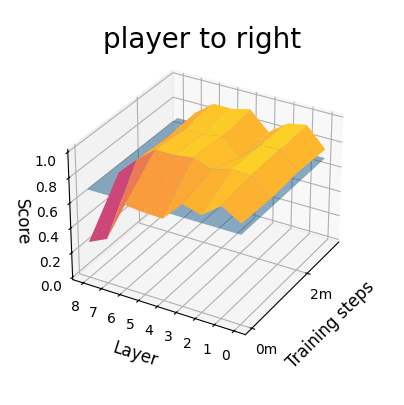

Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 2

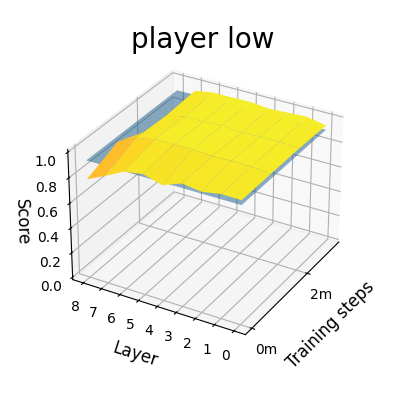

Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, '

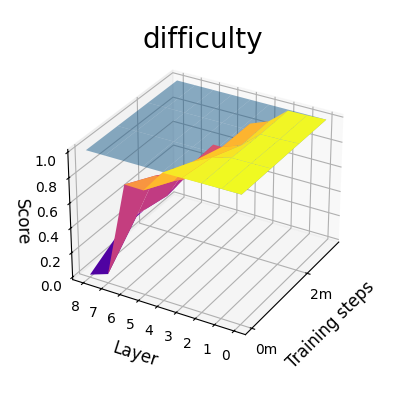

Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epo

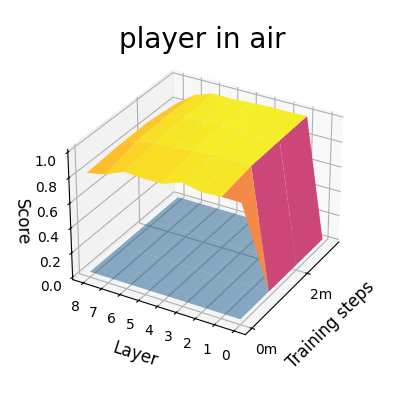

Best hyperparameters: [{'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epo

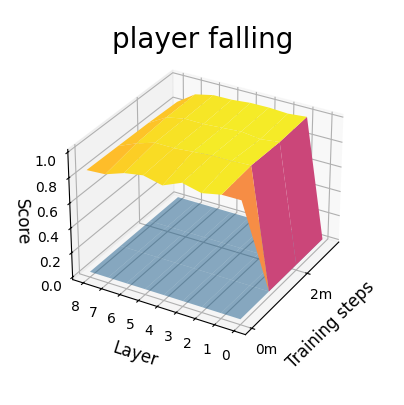

Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epo

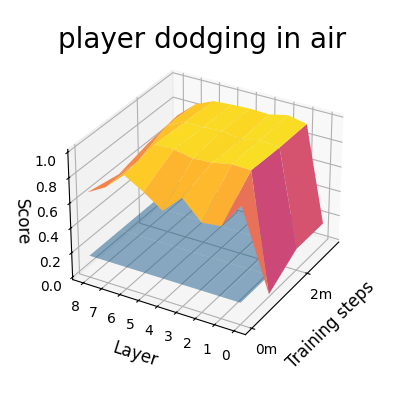

Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'e

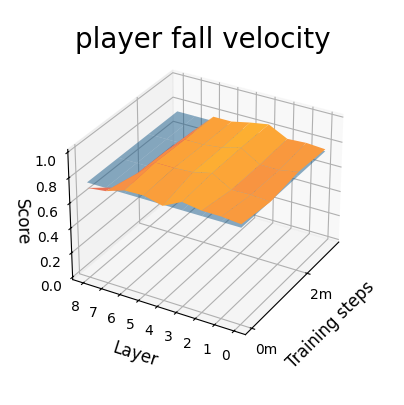

Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'ep

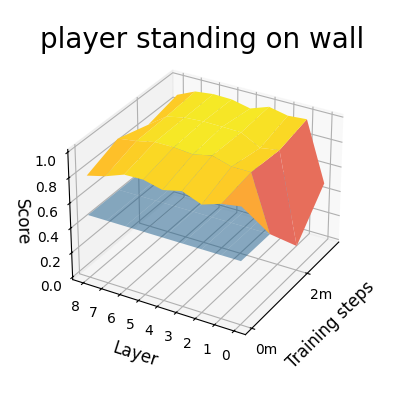

Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epoc

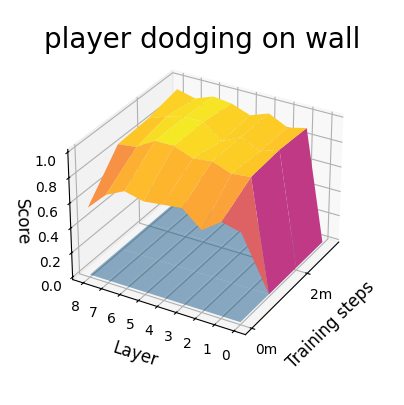

Best hyperparameters: [{'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epoc

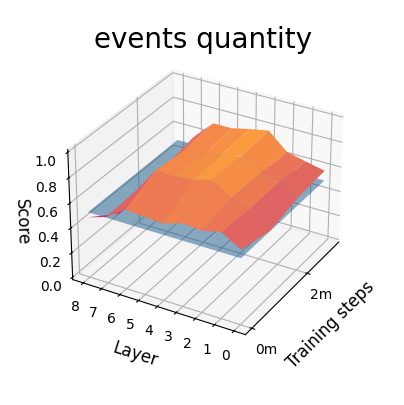

Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epoch

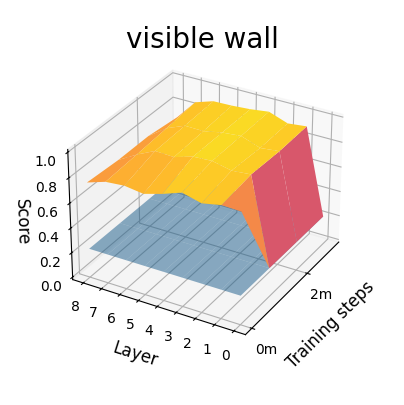

Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epo

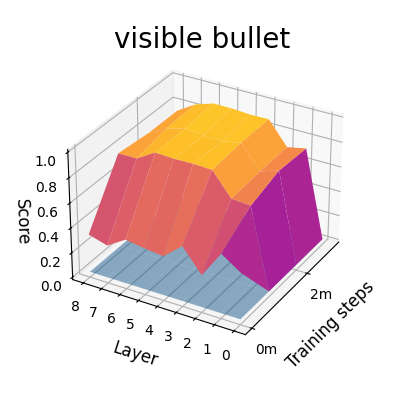

Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10,

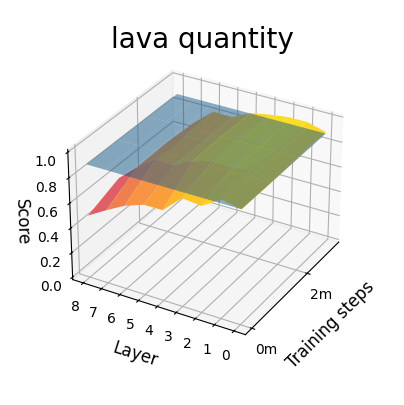

Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, '

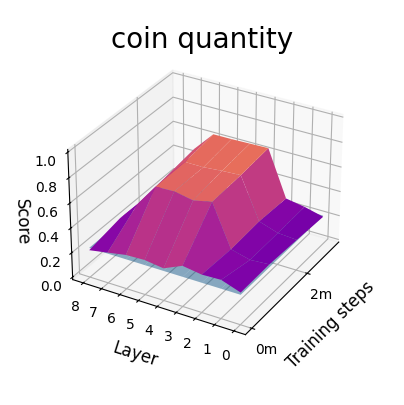

Best hyperparameters: [{'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}]
Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10,

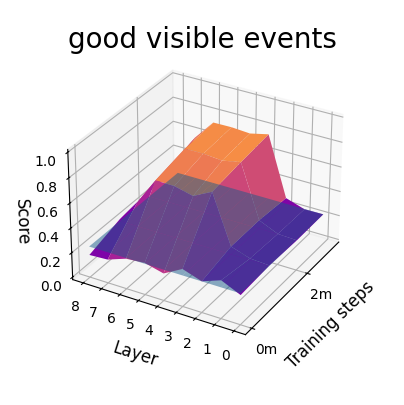

Best hyperparameters: [{'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}]
Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epo

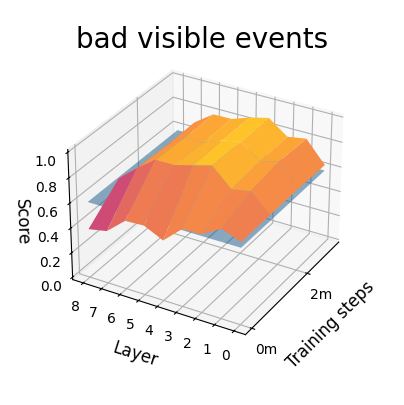

Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs':

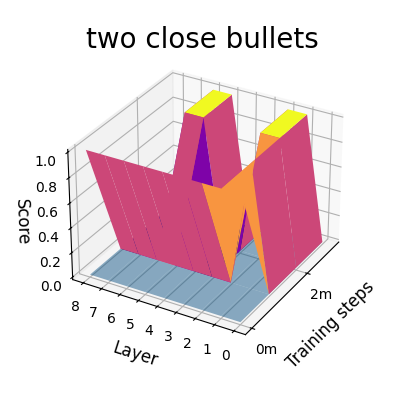

Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}]
Best hyperparameters: [{'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs':

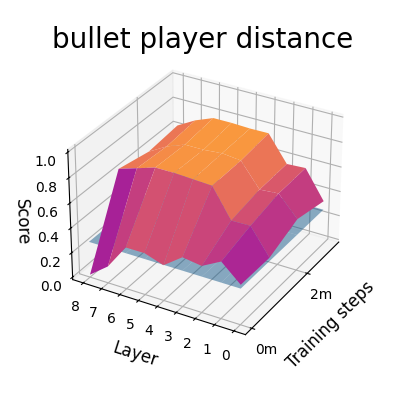

Best hyperparameters: [{'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}]
Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 

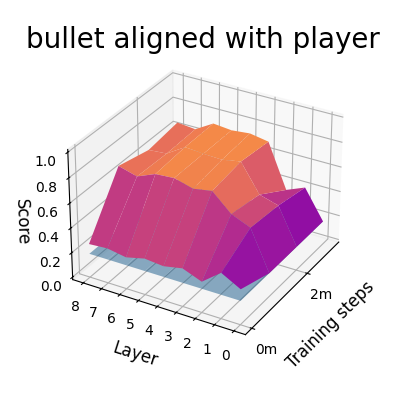

Best hyperparameters: [{'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 1024}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.01, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 128}]
Best hyperparameters: [{'lr': 0.001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 200, 'batch_size': 512}, {'lr': 0.1, 'lambda_l1': 0.0, 'patience': 10, 'epoc

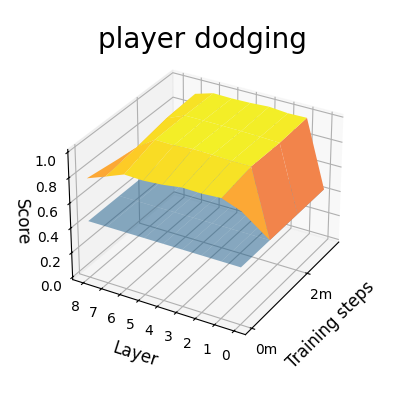

In [6]:
for concept in concept_instances.values():
    create_concept_evolution(concept, models, list(range(9)))